In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('gdelt_data.csv')

df = df[df['Actor1Code'].str.contains('GOV', na=False)]

df['DATE'] = pd.to_datetime(df['SQLDATE'], format='%Y%m%d')
df['YEAR_MONTH'] = df['DATE'].dt.strftime('%Y-%m')
df['WEEK_START'] = df['DATE'].dt.to_period('W').dt.start_time

names = pd.read_csv('gdelt_eventname_match.csv', sep=';')
df = df.merge(names, on='EventCode', how='left')

df = df[df.Confidence <= 30]

In [2]:
def extract_domain(url):
    domain = url.split('//')[1] if '//' in url else url
    domain = domain.split('/')[0]
    domain = domain.replace('www.', '')
    return domain

df['short_url'] = df['SOURCEURL'].apply(extract_domain)
urls_cnts = df.short_url.value_counts().reset_index()
threshold = urls_cnts[urls_cnts['count'] >= 2]
df = df[df.short_url.isin(threshold.short_url)]

In [3]:
express_threaten = [
    'Threaten, not specified below',
    'Threaten to halt negotiations',
    'Threaten to boycott, embargo, or sanction',
]

express_intent = [
    "Express intent to provide material aid, not specified below",
    "Express intent to provide military aid",
    "Express intent to cooperate economically",
    "Express intent to provide economic aid",
    'Express intent to cooperate militarily'
]

df_threaten = df[df['EventName'].isin(express_threaten)].copy()
df_intent   = df[df['EventName'].isin(express_intent)].copy()

In [4]:
weekly_threaten = df_threaten.groupby('WEEK_START').size()
weekly_intent   = df_intent.groupby('WEEK_START').size()

all_weeks = pd.date_range(start='2023-07-10', end='2025-03-01', freq='W-MON')

weekly_df = pd.DataFrame({
    'WEEK_START': all_weeks,
    'express_threaten': weekly_threaten.reindex(all_weeks, fill_value=0).values,
    'express_intent_to_cooperate': weekly_intent.reindex(all_weeks, fill_value=0).values,
})

final_metrics = weekly_df.copy()

In [5]:
variables = pd.read_csv('variables.csv') 
variables['WEEK_START'] = pd.to_datetime(variables['WEEK_START'])

final_metrics = final_metrics.merge(variables, how='left')
final_metrics = final_metrics.fillna(0)
final_metrics.head()

,WEEK_START,express_threaten,express_intent_to_cooperate,Unnamed: 0,escalation,return_hostages,protests,rhetoric_position,fatalities_isr
0,2023-07-10,4,0,0,0,1.0,95.0,0.0,0.0
1,2023-07-17,3,0,1,1,0.0,144.0,0.0,0.0
2,2023-07-24,3,0,2,0,0.0,67.0,0.0,0.0
3,2023-07-31,1,1,3,0,1.0,31.0,0.0,2.0
4,2023-08-07,2,0,4,0,0.0,58.0,-1.0,0.0


# Описательные статистики

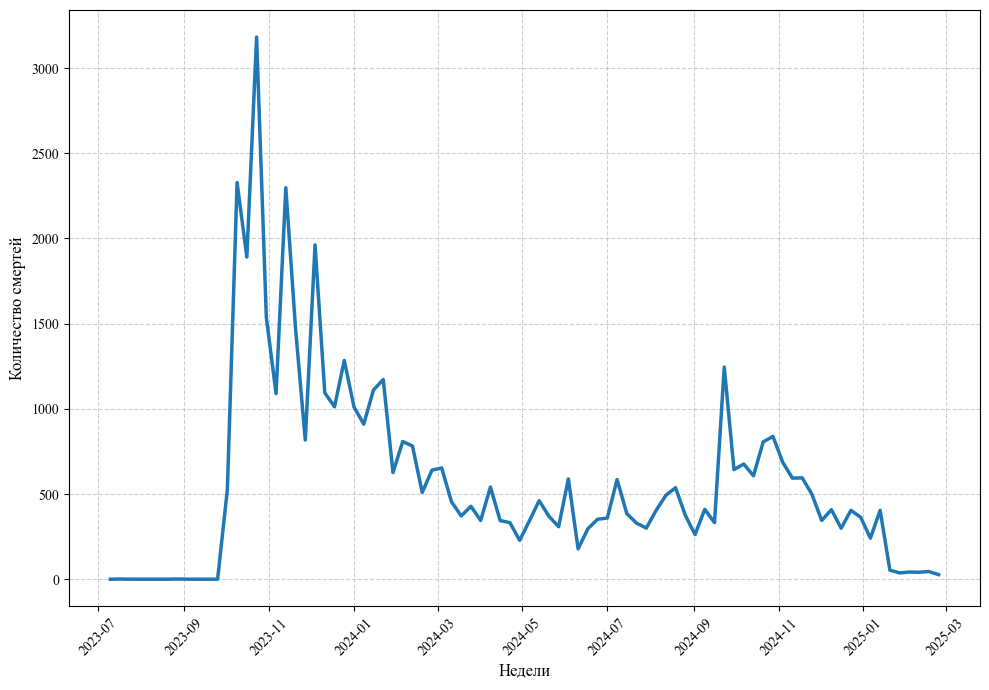

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='escalation', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество смертей', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('escalation.png', dpi=300)
plt.show()

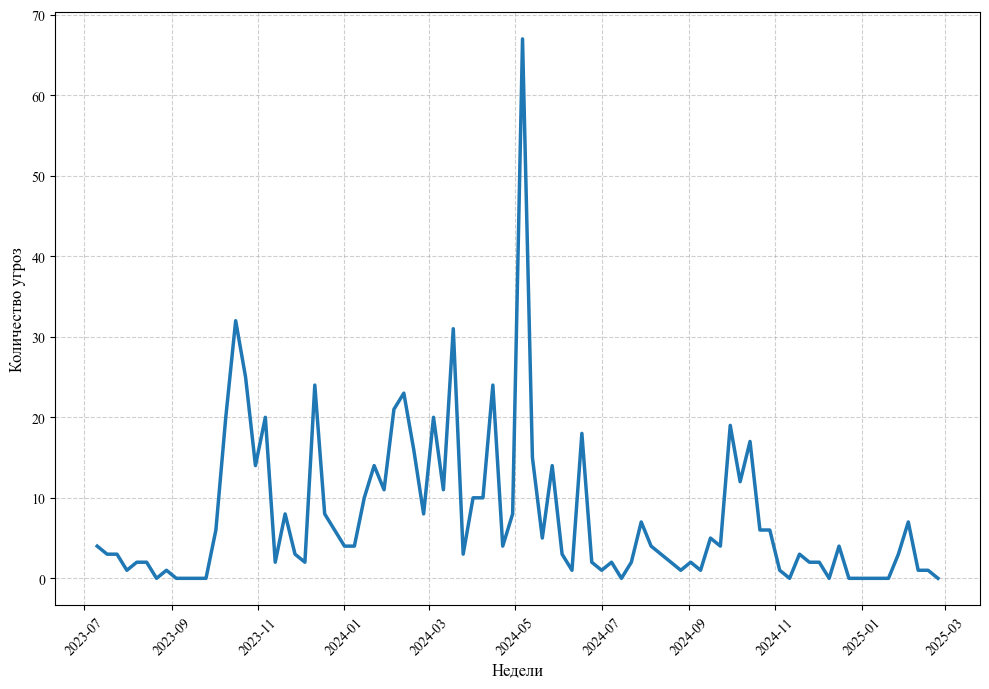

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='express_threaten', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество угроз', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('threaten.png', dpi=300)
plt.show()

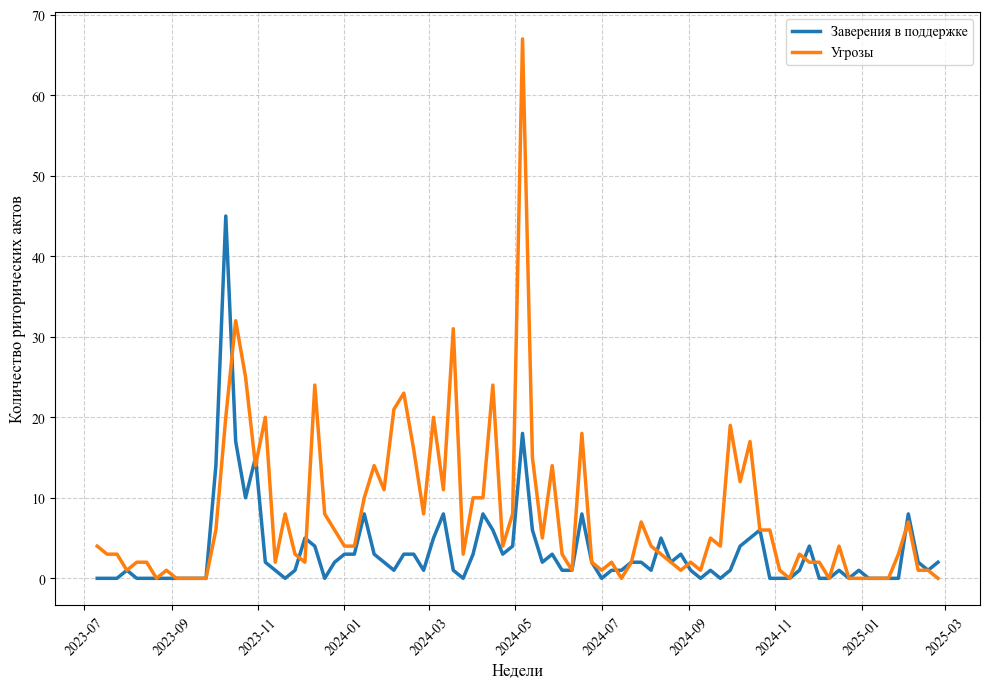

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='express_intent_to_cooperate', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5,
    label='Заверения в поддержке'  
)

sns.lineplot(
    x='WEEK_START', 
    y='express_threaten', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5,
    label='Угрозы'  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество риторических актов', fontsize=12)  
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('cooperate_and_threaten.png', dpi=300)
plt.show()

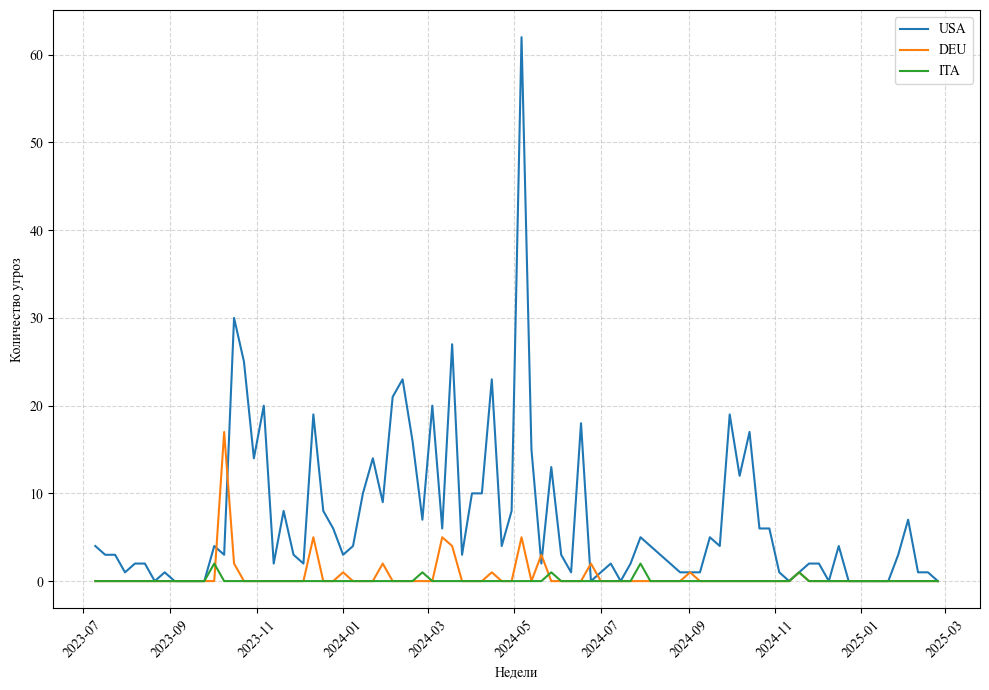

<Figure size 640x480 with 0 Axes>

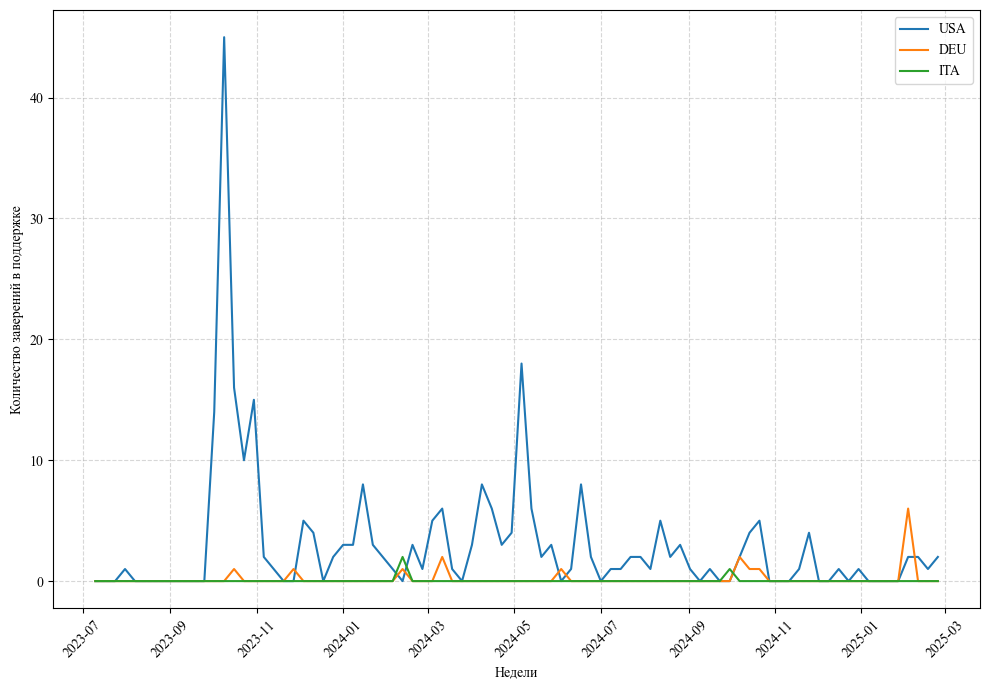

<Figure size 640x480 with 0 Axes>

In [9]:
all_weeks = pd.date_range('2023-07-10','2025-03-01',freq='W-MON')
countries = df['Actor1CountryCode'].unique()
midx = pd.MultiIndex.from_product([countries, all_weeks], names=['Actor1CountryCode','WEEK_START'])

threat = (
    df[df['EventName'].isin(express_threaten)]
    .groupby(['Actor1CountryCode','WEEK_START'])
    .size()
    .reindex(midx, fill_value=0)
    .rename('threaten')
)

intent = (
    df[df['EventName'].isin(express_intent)]
    .groupby(['Actor1CountryCode','WEEK_START'])
    .size()
    .reindex(midx, fill_value=0)
    .rename('intent')
)

country_metrics = pd.DataFrame({'threaten':threat, 'intent':intent}).reset_index()

for var, fname, yname in [('threaten','threaten.png', 'Количество угроз'), ('intent','intent.png', 'Количество заверений в поддержке')]:
    fig, ax = plt.subplots(figsize=(10,7))
    sns.lineplot(
        data=country_metrics,
        x='WEEK_START',
        y=var,
        hue='Actor1CountryCode',
        linewidth=1.5,
        ax=ax
    )
    ax.set_xlabel('Недели')
    ax.set_ylabel(yname)
    ax.legend(title='')           # убираем заголовок легенды
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.show()
    plt.clf()

In [10]:
threat_sum = threat.groupby(level='Actor1CountryCode').sum()
intent_sum = intent.groupby(level='Actor1CountryCode').sum()

summary = pd.DataFrame({
    'threat_count': threat_sum,
    'intent_count': intent_sum
})
summary['threat_share'] = summary['threat_count'] / summary['threat_count'].sum()
summary['intent_share'] = summary['intent_count'] / summary['intent_count'].sum()

summary = summary.sort_values('threat_count', ascending=False)

print(summary)

                   threat_count  intent_count  threat_share  intent_share
Actor1CountryCode                                                        
USA                         605           259       0.91528      0.931655
DEU                          49            16       0.07413      0.057554
ITA                           7             3       0.01059      0.010791


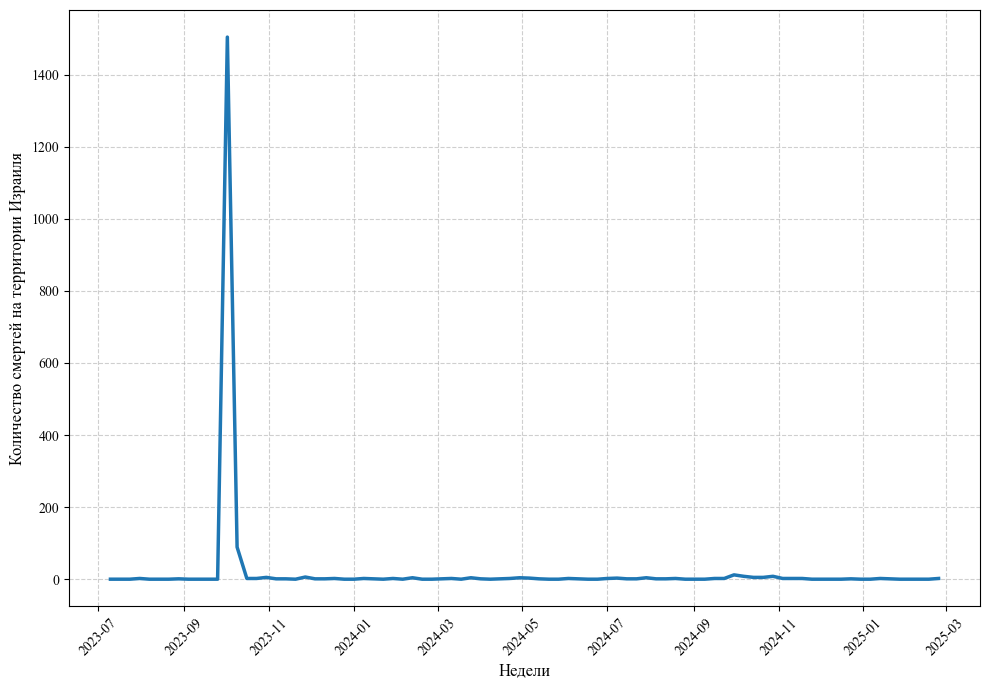

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='fatalities_isr', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество смертей на территории Израиля', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('fatalities_isr.png', dpi=300)
plt.show()

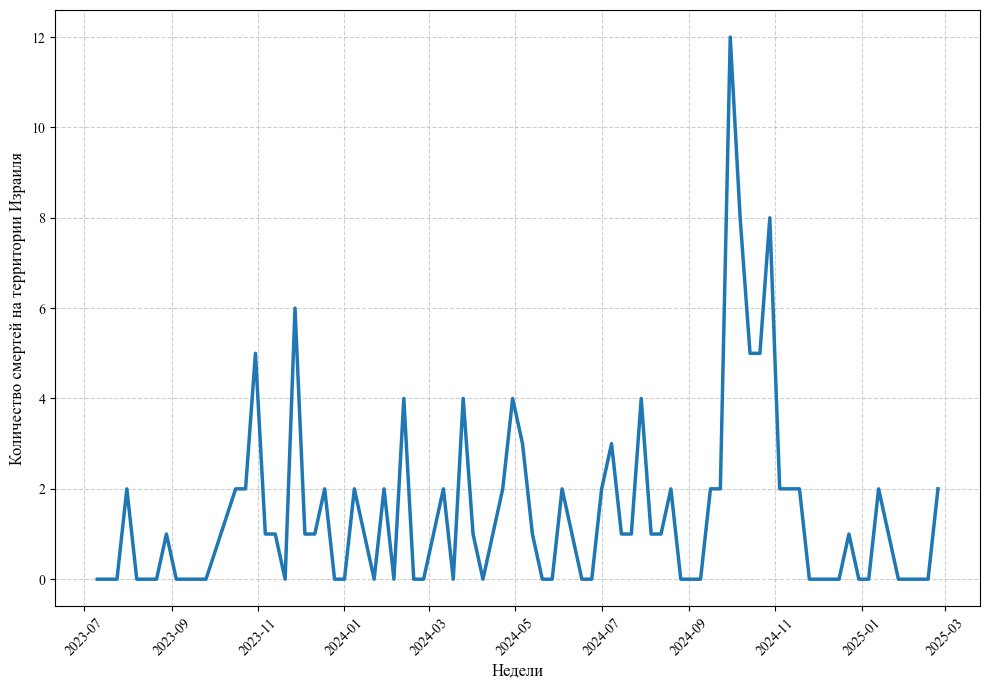

In [12]:
filtered_metrics = final_metrics.copy()
max_values = filtered_metrics['fatalities_isr'].nlargest(2)
filtered_metrics = filtered_metrics[~filtered_metrics['fatalities_isr'].isin(max_values)]

fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='fatalities_isr', 
    data=filtered_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество смертей на территории Израиля', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('fatalities_isr_wo_2_most.png', dpi=300)
plt.show()

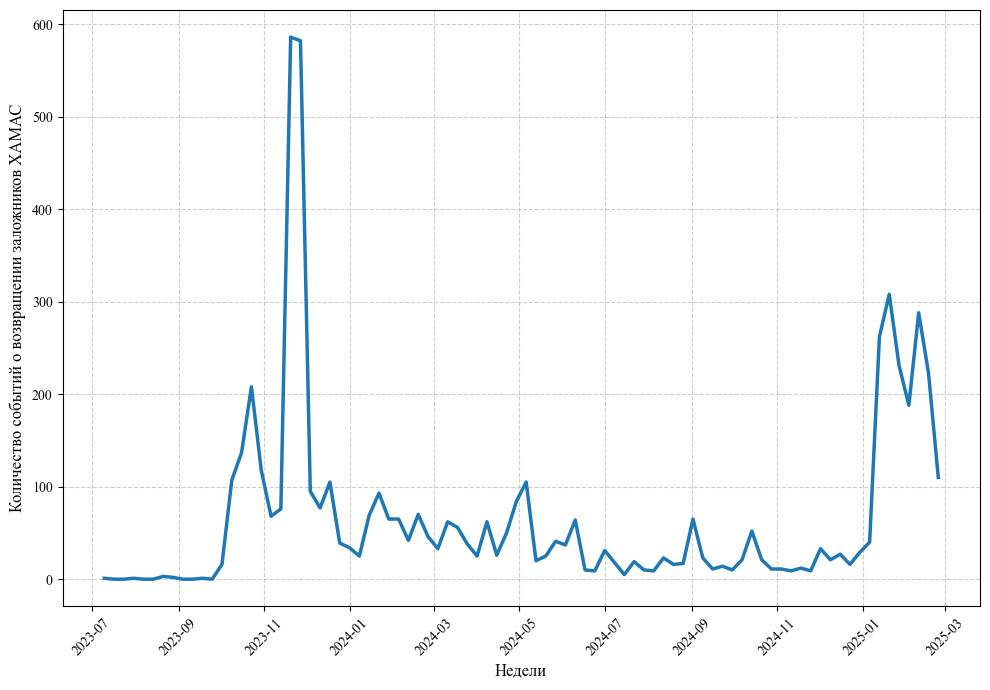

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='return_hostages', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество событий о возвращении заложников ХАМАС', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('hostages.png', dpi=300)
plt.show()

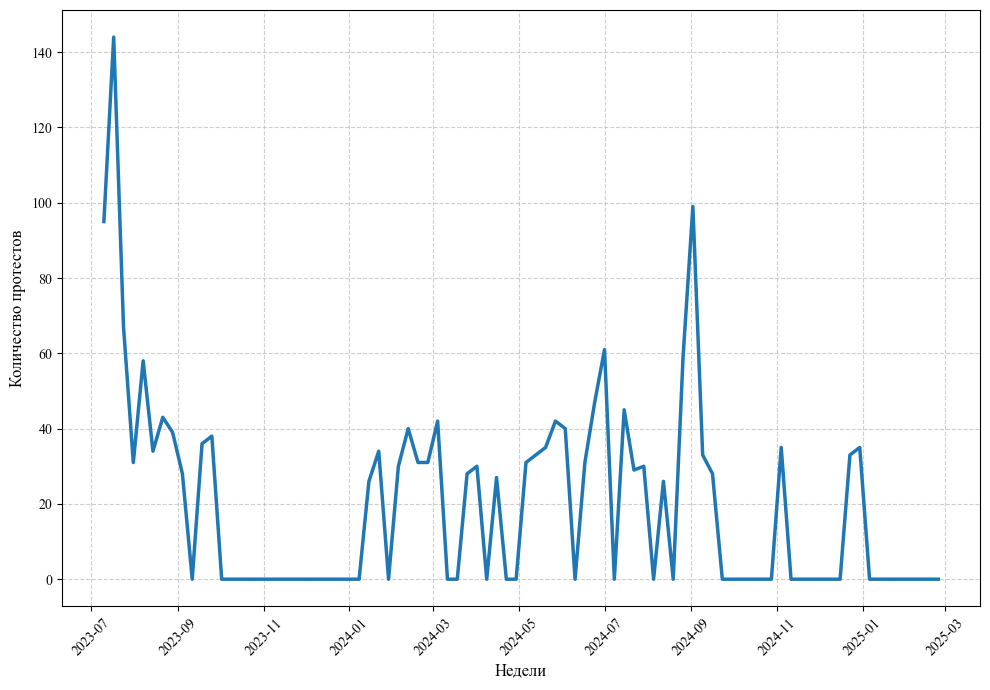

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='protests', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Количество протестов', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('protests.png', dpi=300)
plt.show()

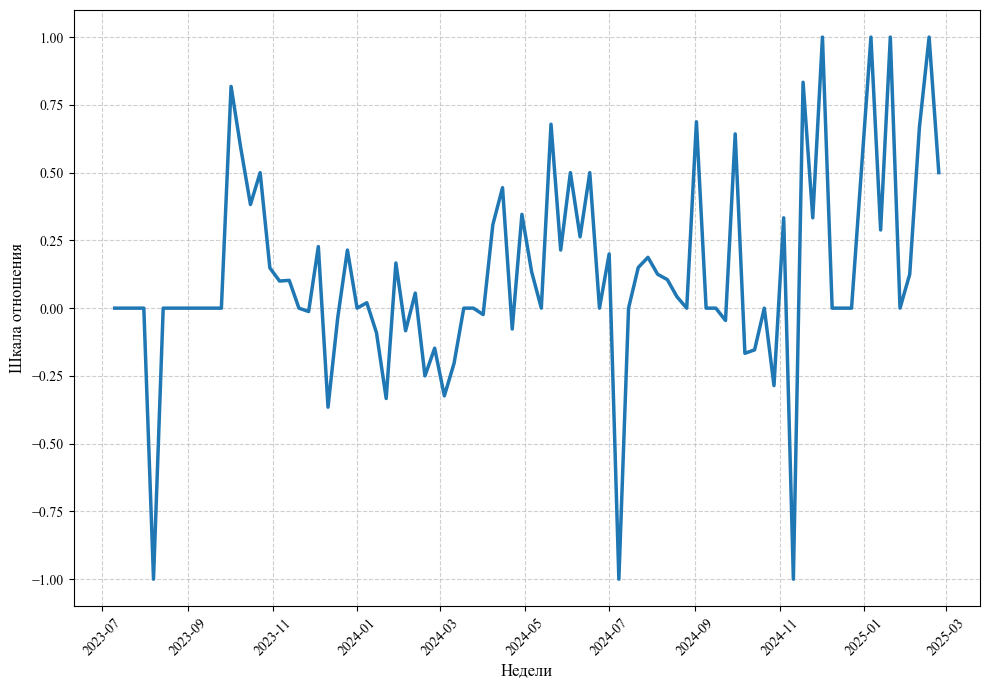

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    x='WEEK_START', 
    y='rhetoric_position', 
    data=final_metrics, 
    ax=ax,  
    linewidth=2.5  
)

ax.set_xlabel('Недели', fontsize=12)
ax.set_ylabel('Шкала отношения', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6) 
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('rhetorical.png', dpi=300)
plt.show()

# Модель 1: Заверения в поддержке и угрозы

In [16]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

var_data = final_metrics[['escalation', 'express_threaten', 'express_intent_to_cooperate', 'protests', 'return_hostages', 'fatalities_isr']].dropna().copy()

diff_needed = {}
stationarized = pd.DataFrame(index=var_data.index)
print("Тест на стационарность (ADF):")
for column in var_data.columns:
    series = var_data[column]
    adf_result = adfuller(series)
    print(f"\n{column}:")
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    if adf_result[1] > 0.05:
        print(f'Ряд {column} нестационарен, берём первую разность')
        series = series.diff().dropna()
        adf_result2 = adfuller(series)
        print(f'    После разности: ADF Statistic = {adf_result2[0]}, p-value = {adf_result2[1]}')
    stationarized[column] = series

stationarized = stationarized.dropna()
model = VAR(stationarized)
lag_order_results = model.select_order(maxlags=2)
print("Оптимальное количество лагов:")
print(lag_order_results.summary())

optimal_lag = lag_order_results.aic

model_fitted = model.fit(optimal_lag)

Тест на стационарность (ADF):

escalation:
ADF Statistic: -2.658077708301753
p-value: 0.0815778009988381
Ряд escalation нестационарен, берём первую разность
    После разности: ADF Statistic = -5.123775055828291, p-value = 1.2555158263295819e-05

express_threaten:
ADF Statistic: -6.406486230489048
p-value: 1.9375549521749577e-08

express_intent_to_cooperate:
ADF Statistic: -5.382183738563434
p-value: 3.6916128116700005e-06

protests:
ADF Statistic: -5.350190657888302
p-value: 4.30628230653658e-06

return_hostages:
ADF Statistic: -2.7867027851846813
p-value: 0.060198428060432824
Ряд return_hostages нестационарен, берём первую разность
    После разности: ADF Statistic = -10.926787229580937, p-value = 1.0054912461762572e-19

fatalities_isr:
ADF Statistic: -6.322334394022355
p-value: 3.044575949987454e-08
Оптимальное количество лагов:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [17]:
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     02:26:34
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    45.3674
Nobs:                     83.0000    HQIC:                   44.0075
Log likelihood:          -2417.04    FPE:                5.27697e+18
AIC:                      43.0943    Det(Omega_mle):     2.20407e+18
--------------------------------------------------------------------
Results for equation escalation
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -84.050796        55.472367           -1.515           0.130
L1.escalation                         -0.693258         0.093459           -7.418    

# Модель 2: риторика

In [18]:
var_data = final_metrics[['escalation',  'rhetoric_position', 'protests', 'return_hostages', 'fatalities_isr']].dropna().copy()

diff_needed = {}
stationarized = pd.DataFrame(index=var_data.index)
print("Тест на стационарность (ADF):")
for column in var_data.columns:
    series = var_data[column]
    adf_result = adfuller(series)
    print(f"\n{column}:")
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    if adf_result[1] > 0.05:
        print(f'Ряд {column} нестационарен, берём первую разность')
        series = series.diff().dropna()
        adf_result2 = adfuller(series)
        print(f'    После разности: ADF Statistic = {adf_result2[0]}, p-value = {adf_result2[1]}')
    stationarized[column] = series

stationarized = stationarized.dropna()
model = VAR(stationarized)
lag_order_results = model.select_order(maxlags=2)
print("\nОптимальное количество лагов:")
print(lag_order_results.summary())

optimal_lag = lag_order_results.aic

model_fitted = model.fit(2)

Тест на стационарность (ADF):

escalation:
ADF Statistic: -2.658077708301753
p-value: 0.0815778009988381
Ряд escalation нестационарен, берём первую разность
    После разности: ADF Statistic = -5.123775055828291, p-value = 1.2555158263295819e-05

rhetoric_position:
ADF Statistic: -4.28666586280809
p-value: 0.0004684323996098642

protests:
ADF Statistic: -5.350190657888302
p-value: 4.30628230653658e-06

return_hostages:
ADF Statistic: -2.7867027851846813
p-value: 0.060198428060432824
Ряд return_hostages нестационарен, берём первую разность
    После разности: ADF Statistic = -10.926787229580937, p-value = 1.0054912461762572e-19

fatalities_isr:
ADF Statistic: -6.322334394022355
p-value: 3.044575949987454e-08

Оптимальное количество лагов:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       35.47      35.61*   2.530e+15       35.53
1       35.06       35.93   1.684e+15      35.41*
2 

/opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [19]:
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, May, 2025
Time:                     02:26:34
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    36.5781
Nobs:                     83.0000    HQIC:                   35.6192
Log likelihood:          -1985.33    FPE:                1.55950e+15
AIC:                      34.9753    Det(Omega_mle):     8.37019e+14
--------------------------------------------------------------------
Results for equation escalation
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                      -83.587887        54.102207           -1.545           0.122
L1.escalation               -0.695020         0.109332           -6.357           0.000
L1.rhetoric_position       